# Calculate SF on 100km slice of QG outputs

In [9]:
# imports
from importlib import reload
import os

import xarray

import numpy as np
# import fsspec
import matplotlib
import matplotlib.pyplot as plt
import gsw_xarray as gsw
from xhistogram.xarray import histogram

from dask.diagnostics import ProgressBar

from strucFunct2_ai import timescale

from profiler import gliderdata
from profiler import profilerpairs
from cugn import io as cugn_io
from cugn import utils as cugn_utils
from cugn import plotting as cugn_plotting

import qg_utils
import strucFunct2_ai

# Load up

In [2]:
qg, mSF_15 = qg_utils.load_qg()

In [18]:
mSF_15

<xarray.Dataset> Size: 5MB
Dimensions:    (time: 1824, mid_rbins: 59)
Coordinates:
    lev        int64 8B ...
  * time       (time) float64 15kB 5.373e+03 5.374e+03 ... 7.195e+03 7.196e+03
  * mid_rbins  (mid_rbins) float64 472B 2.5e+03 7.5e+03 ... 2.875e+05 2.925e+05
Data variables:
    dr         (time, mid_rbins) float64 861kB dask.array<chunksize=(100, 53), meta=np.ndarray>
    ulls       (time, mid_rbins) float64 861kB dask.array<chunksize=(100, 53), meta=np.ndarray>
    utts       (time, mid_rbins) float64 861kB dask.array<chunksize=(100, 53), meta=np.ndarray>
    du2        (time, mid_rbins) float64 861kB dask.array<chunksize=(100, 53), meta=np.ndarray>
    du3        (time, mid_rbins) float64 861kB dask.array<chunksize=(100, 53), meta=np.ndarray>
    du1        (time, mid_rbins) float64 861kB dask.array<chunksize=(100, 53), meta=np.ndarray>
Attributes:
    description:  Structure Function Dataset
    Model:        Two-layer QG Turbulence

# Cut down grid

In [4]:
# Calculates structure functions
shiftdim = 'x','y'
maxcorr = 30
grid = 'm'

# rbins = np.arange(1e3, 2e5, 4e3)

# Gets last 6 months of data
nmonths = 6
month = 30
#yr = 365

i1 = -2-month*nmonths
time6m = np.arange(i1, i1 + month*nmonths)

In [6]:
inner100 = np.where((qg.x >= 400*1e3) & (qg.x < 500.*1e3))[0]
inner100

array([102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127])

In [7]:
# Chunks data

chx = len(qg.x)
chy = len(qg.y)
cht = len(qg.time)

chunks = {'x': chx, 'y': chy, 'time': cht}

Udsn = qg.isel(lev=0, time=time6m, x=inner100, y=inner100).chunk(chunks)
Udsn

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 180, y: 26, x: 26, lev_mid: 1, l: 256, k: 129)
Coordinates:
  * time     (time) float64 1kB 6.064e+08 6.064e+08 ... 6.217e+08 6.218e+08
    lev      int64 8B 1
  * lev_mid  (lev_mid) float64 8B 1.5
  * x        (x) float64 208B 4.004e+05 4.043e+05 ... 4.941e+05 4.98e+05
  * y        (y) float64 208B 4.004e+05 4.043e+05 ... 4.941e+05 4.98e+05
  * l        (l) float64 2kB 0.0 6.283e-06 1.257e-05 ... -1.257e-05 -6.283e-06
  * k        (k) float64 1kB 0.0 6.283e-06 1.257e-05 ... 0.000798 0.0008042
Data variables:
    q        (time, y, x) float64 973kB dask.array<chunksize=(180, 26, 26), meta=np.ndarray>
    u        (time, y, x) float64 973kB dask.array<chunksize=(180, 26, 26), meta=np.ndarray>
    v        (time, y, x) float64 973kB dask.array<chunksize=(180, 26, 26), meta=np.ndarray>
Attributes: (12/23)
    pyqg:beta:       1.5e-11
    pyqg:delta:      0.25
    pyqg:del2:       0.8
    pyqg:dt:         3600.0
    pyqg:filterfac:  23.6
    pyqg:L:          1000000.0
    ...              ...
    pyqg:tc:         0
    pyqg:tmax:       622080000.0
    pyqg:twrite:     10000
    pyqg:W:          1000000.0
    title:           pyqg: Python Quasigeostrophic Model
    reference:       https://pyqg.readthedocs.io/en/latest/index.html

# SF

## Test

In [10]:
SFtest = strucFunct2_ai.calculateSF_2(Udsn.isel(time=np.arange(0, 15)), maxcorr, shiftdim, grid)

[########################################] | 100% Completed | 23.20 s


Concatenating results:   0%|          | 0/899 [00:00<?, ?it/s]

In [11]:
SFtest

<xarray.Dataset> Size: 219MB
Dimensions:  (x: 26, y: 26, time: 15, dcorr: 899)
Coordinates:
    lev      int64 8B 1
  * x        (x) float64 208B 4.004e+05 4.043e+05 ... 4.941e+05 4.98e+05
  * y        (y) float64 208B 4.004e+05 4.043e+05 ... 4.941e+05 4.98e+05
  * time     (time) float64 120B 6.064e+08 6.064e+08 ... 6.075e+08 6.076e+08
Dimensions without coordinates: dcorr
Data variables:
    dr       (dcorr, x, y, time) float64 73MB nan nan nan nan ... nan nan nan
    ulls     (dcorr, x, y, time) float64 73MB nan nan nan nan ... nan nan nan
    utts     (dcorr, x, y, time) float64 73MB nan nan nan nan ... nan nan nan

In [21]:
reload(strucFunct2_ai)
SF2, SF3 = strucFunct2_ai.SF2_3_ul(SFtest.ulls)

### Ensemble average

In [23]:
# Slice the data to include the current chunk
data_slice = SFtest.isel(time=slice(0,15))
    
# Calculates du1, du2 and du3
sf2, sf3 = strucFunct2_ai.SF2_3_ul(data_slice.ulls)#, data_slice.dut)
data_slice['du2'] = sf2
data_slice['du3'] = sf3
    
# Averages over all $s$ positions
with ProgressBar():
    data_avers = data_slice.mean(dim=('x','y'), skipna=True).compute()

In [24]:
data_avers

<xarray.Dataset> Size: 540kB
Dimensions:  (time: 15, dcorr: 899)
Coordinates:
    lev      int64 8B 1
  * time     (time) float64 120B 6.064e+08 6.064e+08 ... 6.075e+08 6.076e+08
Dimensions without coordinates: dcorr
Data variables:
    dr       (dcorr, time) float64 108kB 3.906e+03 3.906e+03 ... nan nan
    ulls     (dcorr, time) float64 108kB -0.001125 -0.001142 ... nan nan
    utts     (dcorr, time) float64 108kB -0.005117 -0.00522 ... nan nan
    du2      (dcorr, time) float64 108kB 2.328e-05 2.269e-05 ... nan nan
    du3      (dcorr, time) float64 108kB -8.616e-08 -8.563e-08 ... nan nan

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_329812/3043742909.py:4: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('$\delta u1(\mathbf{r}, t)$ [m s$^{-1}$]')


Text(0, 0.5, '$\\delta u1(\\mathbf{r}, t)$ [m s$^{-1}$]')

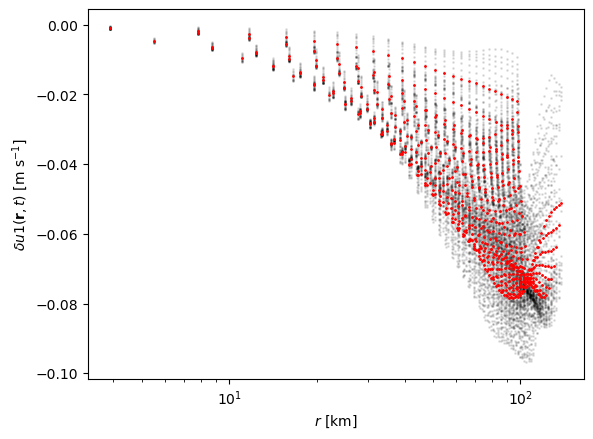

In [28]:
plt.semilogx(data_avers.dr*1e-3, data_avers.ulls, '.k', markersize=2, alpha=0.1)
plt.semilogx(data_avers.dr.mean('time')*1e-3, data_avers.ulls.mean('time'), '.r', markersize=2)
plt.xlabel('$r$ [km]')
plt.ylabel('$\delta u1(\mathbf{r}, t)$ [m s$^{-1}$]')

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_329812/794183972.py:4: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('$\delta u3(\mathbf{r}, t)$ [m$^3$ s$^{-3}$]')


Text(0, 0.5, '$\\delta u3(\\mathbf{r}, t)$ [m$^3$ s$^{-3}$]')

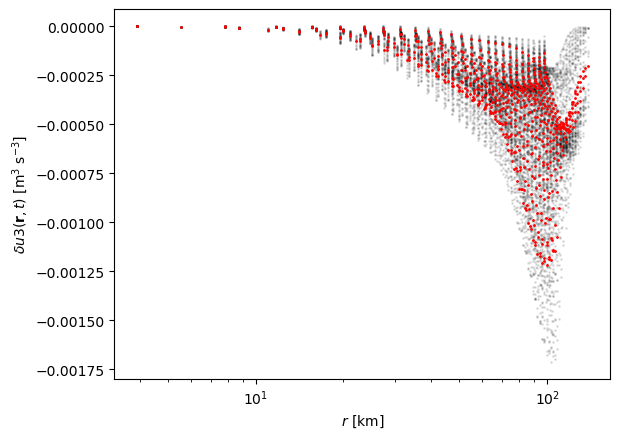

In [26]:
plt.semilogx(data_avers.dr*1e-3, data_avers.du3, '.k', markersize=2, alpha=0.1)
plt.semilogx(data_avers.dr.mean('time')*1e-3, data_avers.du3.mean('time'), '.r', markersize=2)
plt.xlabel('$r$ [km]')
plt.ylabel('$\delta u3(\mathbf{r}, t)$ [m$^3$ s$^{-3}$]')

### Average over orientation

In [51]:
# Defines distance bins 
dr = 5000 # meters
rbins = np.arange(0, 1.3e5, dr) # 130 km
mid_rbins = 0.5*(rbins[:-1] + rbins[1:])

In [44]:
dudlt_aver_angl = strucFunct2_ai.process_SF_samples(data_avers, rbins, mid_rbins)

  0%|          | 0/15 [00:00<?, ?it/s]

In [45]:
dudlt_aver_angl

<xarray.Dataset> Size: 15kB
Dimensions:    (time: 15, mid_rbins: 25)
Coordinates:
    lev        int64 8B 1
  * time       (time) float64 120B 6.064e+08 6.064e+08 ... 6.075e+08 6.076e+08
  * mid_rbins  (mid_rbins) float64 200B 2.5e+03 7.5e+03 ... 1.175e+05 1.225e+05
Data variables:
    dr         (time, mid_rbins) float64 3kB 2.5e+03 7.5e+03 ... 1.225e+05
    ulls       (time, mid_rbins) float64 3kB -0.001155 -0.004622 ... -0.07938
    utts       (time, mid_rbins) float64 3kB -0.003025 -0.006368 ... -0.09864
    du2        (time, mid_rbins) float64 3kB 2.394e-05 0.0001508 ... 0.006535
    du3        (time, mid_rbins) float64 3kB -8.919e-08 ... -0.0005554
Attributes:
    description:  Structure Function Dataset
    Model:        Two-layer QG Turbulence

### Plot

In [50]:
dudlt_aver_angl.ulls.T.mean('time')

<xarray.DataArray 'ulls' (mid_rbins: 25)> Size: 200B
array([-0.00093649, -0.00432891, -0.00793985, -0.0106333 , -0.01493859,
       -0.01973512, -0.02417292, -0.02567542, -0.03278917, -0.03635597,
       -0.0384126 , -0.04395188, -0.04781446, -0.05165894, -0.05001193,
       -0.05545183, -0.05913229, -0.0584307 , -0.0602635 , -0.06186895,
       -0.07085325, -0.07248586, -0.07150813, -0.07008313, -0.06759574])
Coordinates:
    lev        int64 8B 1
  * mid_rbins  (mid_rbins) float64 200B 2.5e+03 7.5e+03 ... 1.175e+05 1.225e+05

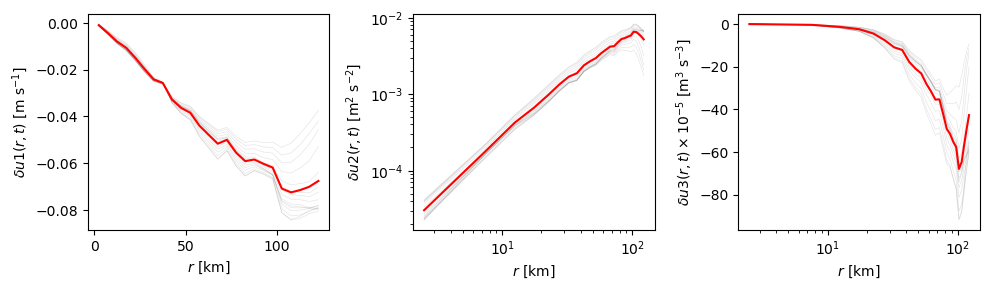

In [54]:
plt.figure(figsize=(10, 3))

#rx, tx = np.meshgrid(dudlt_aver_angl.dr.mean('time')*1e-3, dudlt_aver_angl.time/86400/365)

plt.subplot(1,3,1)
plt.plot(dudlt_aver_angl.dr.mean('time')*1e-3, dudlt_aver_angl.ulls.T, '-k', linewidth=0.5, alpha=0.1)
plt.plot(dudlt_aver_angl.dr.mean('time')*1e-3, dudlt_aver_angl.ulls.T.mean('time'), '-r', linewidth=1.5)
plt.xlabel('$r$ [km]')
plt.ylabel('$\\delta u1(r, t)$ [m s$^{-1}$]')


plt.subplot(1,3,2)
plt.loglog(dudlt_aver_angl.dr.mean('time')*1e-3, dudlt_aver_angl.du2.T, '-k', linewidth=0.5, alpha=0.1)
plt.loglog(dudlt_aver_angl.dr.mean('time')*1e-3, dudlt_aver_angl.du2.T.mean('time'), '-r', linewidth=1.5)
plt.xlabel('$r$ [km]')
plt.ylabel('$\\delta u2(r, t)$ [m$^2$ s$^{-2}$]')


plt.subplot(1,3,3)
plt.semilogx(dudlt_aver_angl.dr.mean('time')*1e-3, dudlt_aver_angl.du3.T*1e5, '-k', linewidth=0.5, alpha=0.1)
plt.semilogx(dudlt_aver_angl.dr.mean('time')*1e-3, dudlt_aver_angl.du3.T.mean('time')*1e5, '-r', linewidth=1.5)
plt.xlabel('$r$ [km]')
plt.ylabel('$\\delta u3(r, t) \\times 10^{-5}$ [m$^3$ s$^{-3}$]')

plt.tight_layout()

# Entire box

In [55]:
# Chunks data

chx = len(qg.x)
chy = len(qg.y)
cht = len(qg.time)

chunks = {'x': chx, 'y': chy, 'time': cht}

Udsn_full = qg.isel(lev=0, time=time6m).chunk(chunks)

In [ ]:
SFtest = strucFunct2_ai.calculateSF_2(Udsn_full.isel(time=np.arange(0, 15)), maxcorr, shiftdim, grid)

[###################                     ] | 47% Completed | 81.72 sms

IOStream.flush timed out


[####################################### ] | 98% Completed | 116.83 s

In [ ]:
# Slice the data to include the current chunk
data_slice = SFtest.isel(time=slice(0,15))
    
# Calculates du1, du2 and du3
sf2, sf3 = strucFunct2_ai.SF2_3_ul(data_slice.ulls)#, data_slice.dut)
data_slice['du2'] = sf2
data_slice['du3'] = sf3
    
# Averages over all $s$ positions
with ProgressBar():
    data_avers = data_slice.mean(dim=('x','y'), skipna=True).compute()

----